1. Laden Sie die Trainingsdaten.

In [61]:
import pandas as pd

train_df =  pd.read_csv('data/train.csv', delimiter=';')
train_df.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0


2. Führen Sie eine kurze EDA durch (Details auf Folie 13).

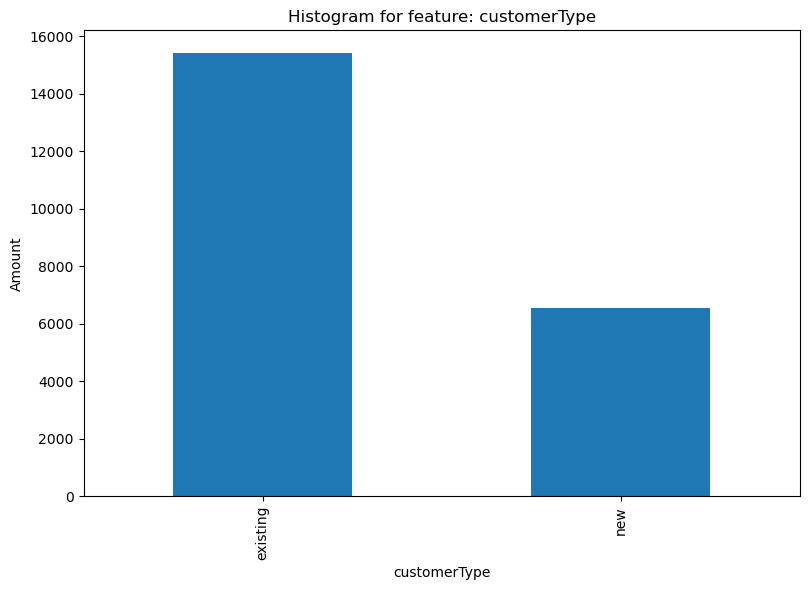

In [62]:
import matplotlib.pyplot as plt

ax = train_df['customerType'].value_counts().plot.bar(figsize=(8, 6), title='Verteilung der customerType')
plt.tight_layout()
plt.title('Histogram for feature: customerType')
ax.set_ylabel('Amount')
plt.show()

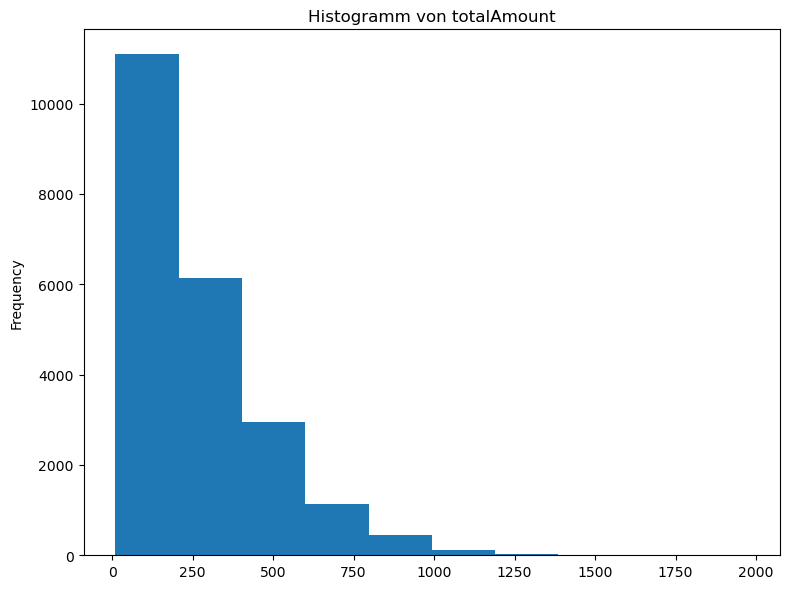

In [63]:
train_df['totalAmount'].plot.hist(bins=10, figsize=(8, 6), title='Histogramm von totalAmount')
plt.tight_layout()
plt.show()

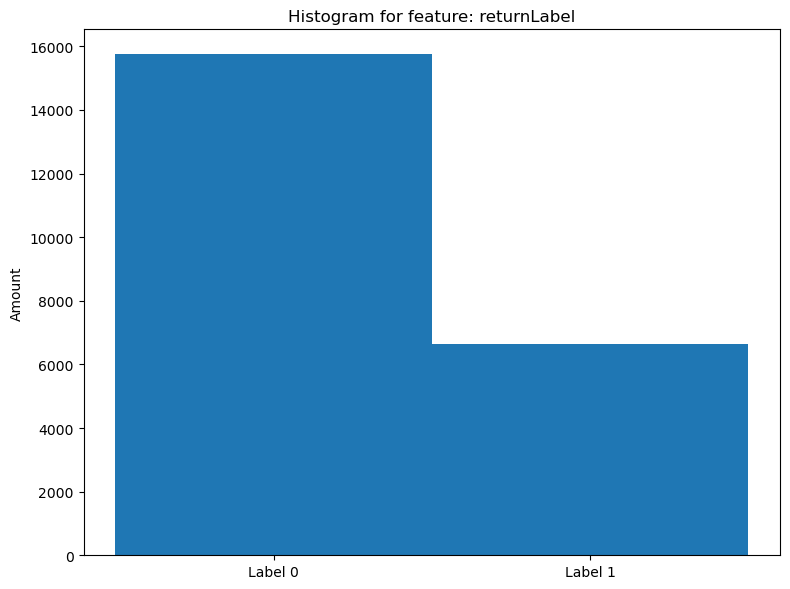

In [73]:
ax = train_df['returnLabel'].plot.hist(bins=2, figsize=(8, 6), title='Histogramm von totalAmount')

plt.title('Histogram for feature: returnLabel')
plt.xticks([0.25, 0.75], ['Label 0', 'Label 1'])
ax.set_ylabel('Amount')
plt.tight_layout()
plt.show()

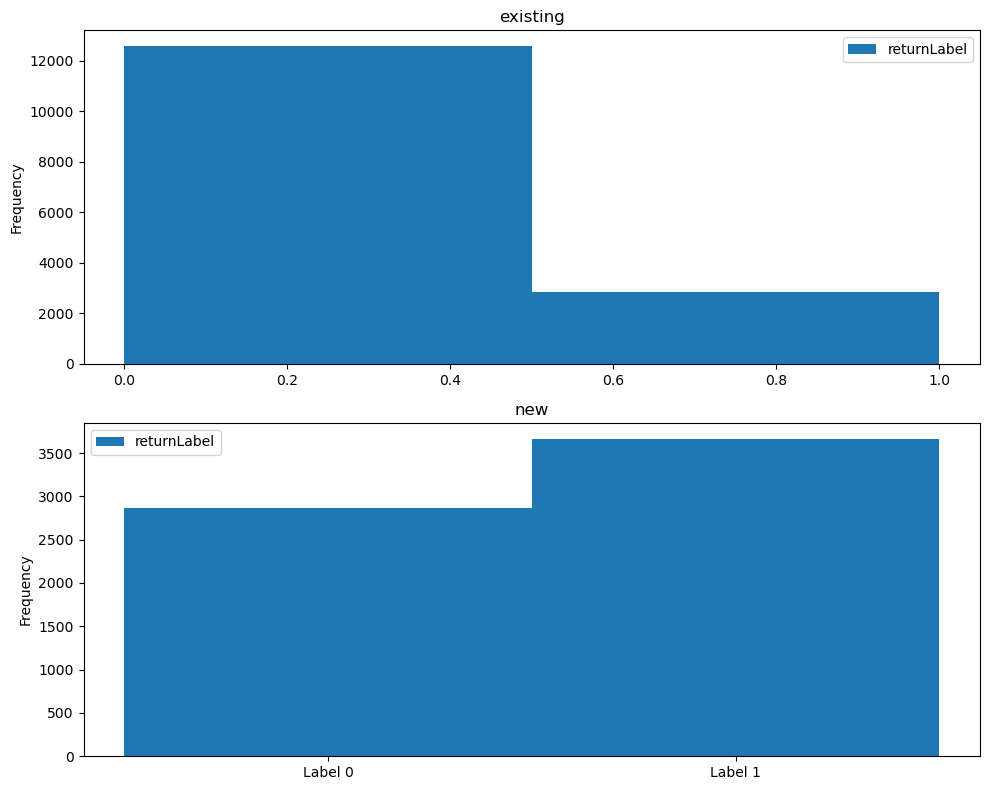

In [65]:
ax = train_df.plot.hist(column=["returnLabel"], by="customerType", figsize=(10, 8), bins=2 )
plt.xticks([0.25, 0.75], ['Label 0', 'Label 1'])
plt.tight_layout()

plt.show()

#TODO: x-Achsenbeschriftung oben besser machen

Text(0, 0.5, 'totalAmount')

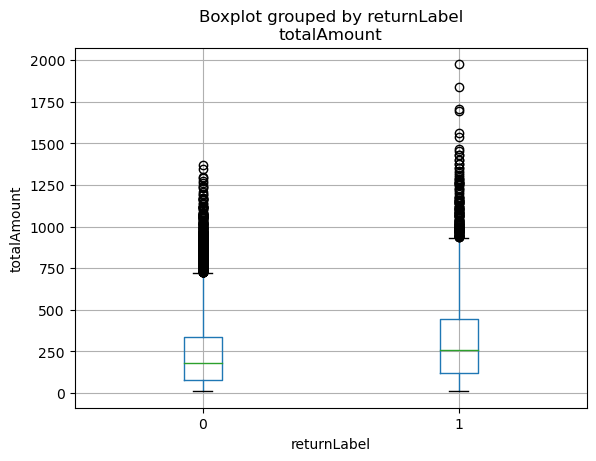

In [66]:
train_df.boxplot(column='totalAmount' , by='returnLabel')
plt.xlabel('returnLabel')
plt.ylabel('totalAmount')

#TODO: stimmt der Plot so? komisch, wegen nan werten?

c:\Users\clara\miniconda3\envs\ml-course\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


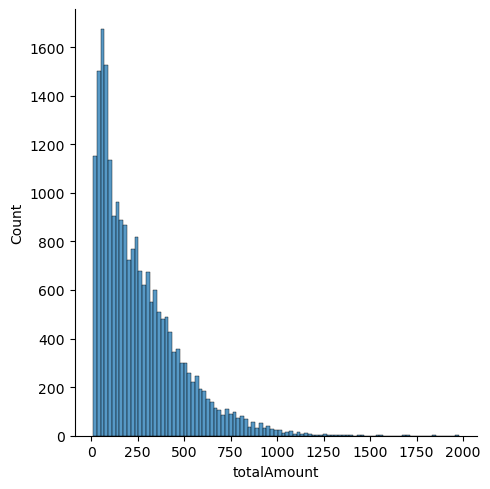

In [67]:
import seaborn as sns
sns.displot(train_df, x='totalAmount')

3. Füllen Sie fehlende Werte in den Trainingsdaten auf.


In [68]:


train_df['totalAmount'] = train_df['totalAmount'].fillna(train_df['totalAmount'].mean())
train_df['customerType'] = train_df['customerType'].fillna(train_df['customerType'].mode()[0])

basket_nan = train_df['basket'].isna().sum().sum()
customerType_nan = train_df['customerType'].isna().sum().sum()
totalAmount_nan = train_df['totalAmount'].isna().sum().sum()
returnLabel_nan = train_df['returnLabel'].isna().sum().sum()
nan_values = train_df.isna().sum().sum()

print(f'Der Datensatz enthält {nan_values} NaN-Werte.')
print(f'basket enthält {basket_nan} NaN-Werte.')
print(f'customerType enthält {customerType_nan} NaN-Werte.')
print(f'totalAmount enthält {totalAmount_nan} NaN-Werte.')
print(f'returnLabel enthält {returnLabel_nan} NaN-Werte.')


Der Datensatz enthält 0 NaN-Werte.
basket enthält 0 NaN-Werte.
customerType enthält 0 NaN-Werte.
totalAmount enthält 0 NaN-Werte.
returnLabel enthält 0 NaN-Werte.


4. Transformieren Sie die kategorischen Features mittels One-hot-encoding.

In [69]:
oh_train_df = pd.get_dummies(train_df, columns=['customerType', 'returnLabel'])
oh_train_df.head()

,transactionId,basket,totalAmount,customerType_existing,customerType_new,returnLabel_0,returnLabel_1
0,9534310106,"[4, 3, 4]",252.0,False,True,False,True
1,7202594767,"[4, 2, 0, 2, 5]",70.0,True,False,True,False
2,2737331698,[5],84.0,True,False,True,False
3,4868011733,"[1, 4, 2, 4]",116.0,True,False,True,False
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",378.0,True,False,True,False


5. Versuchen Sie auf Basis des Attributs basket Features zu bauen (z.B. wie oft
kommt jede Kategorie im Basket vor)

6. Skalieren Sie die Features mit einem StandardScaler.

7. Trainieren Sie die folgenden Klassifikationsmodelle und probieren Sie die
angegebenen Hyperparameter mittels Cross-Validation aus:
    1. Logistische Regression: C :[0.1,1,4,5,6,10,30,100] und penalty: ["l1", "l2"]
    2. Random Forest: n_estimators: [60,80,100,120,140] und max_depth: [2, 4, 6]
    3. Gradient Boosting Tree: gleiche Hyperparameter wie bei Random Forest.

8. Laden Sie die Testdaten

9. Entfernen Sie alle Zeilen mit fehlenden Werten

10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

11. Skalieren Sie die Daten im gleichem Maß wie die Trainingsdaten

12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den
jeweils besten Hyperparametern aus der Cross Validation.

13. Berechnen Sie für jedes der drei Modell Accuracy, Precision und Recall.

14. Berechnen Sie außerdem die Accuracy auf den Trainingsdaten und vergleichen Sie
Accuracy auf Trainings- und Testdaten. Liegt Overfitting vor? (Unterschied > 5%)

5. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen
drei Modellen falsch klassifiziert wurden:
    1. Bestimmen Sie für jedes der drei Modelle die Indizes der Testdatenpunkte auf
    welchen das jeweilige Modell falsch klassifiziert hat.
    2. Nutzen Sie die set-Klasse in Python um die Anzahl an Datenpunkten zu
    bestimmen, welche von allen drei Modellen falsch klassifiziert wurden.

16. Vergleichen Sie die Feature-Importances der drei Modelle in einem Plot